In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 5.11 ms (started: 2022-04-11 02:33:19 +00:00)


In [2]:
'''Basic package'''
import os
import shutil
import copy
import queue
import cv2          #影像處理
import scipy.misc   #影像處理
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt #繪圖
import time

''' pytorch library '''
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()   # interactive mode

time: 1.86 s (started: 2022-04-11 02:33:19 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
time: 2.12 s (started: 2022-04-11 02:33:21 +00:00)


In [4]:
import os
os.chdir(path='./gdrive/MyDrive/SideProject/Orchid recongize/training')

time: 2.1 ms (started: 2022-04-11 02:33:23 +00:00)


In [ ]:
random_state = 878

time: 812 µs (started: 2022-04-10 06:41:35 +00:00)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader,TensorDataset

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=random_state)

In [ ]:
for train_index, test_index in sss.split(df['filename'], df['category']):
  train = df.iloc[train_index, :]
  val = df.iloc[test_index, :]

### Load Data

In [ ]:
def generate_train_val(df, folder_name):
  shutil.rmtree(os.path.join('./data', folder_name))
  os.makedirs(os.path.join('./data', folder_name))
  for i, j  in df.iterrows():
    os.makedirs(os.path.join('./data', folder_name, str(j[1])), exist_ok=True)
    shutil.copyfile(os.path.join('./data', str(j[1]), j[0]), os.path.join('./data', folder_name, str(j[1]), j[0]))

In [ ]:
# generate_train_val(train, 'train')

In [ ]:
# generate_train_val(val, 'val')

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 上下左右中心裁剪
        transforms.RandomHorizontalFlip(),  # 随机长宽比裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # from ImageNet data
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),  # 中心裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

time: 15 ms (started: 2022-04-11 02:33:32 +00:00)


In [6]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
display(image_datasets)

{'train': Dataset ImageFolder
     Number of datapoints: 1752
     Root location: data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 438
     Root location: data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

time: 505 ms (started: 2022-04-11 02:33:32 +00:00)


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
display(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f843b080150>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f843ca48490>}

time: 9.15 ms (started: 2022-04-11 02:33:33 +00:00)


In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
display(dataset_sizes)

{'train': 1752, 'val': 438}

time: 5.3 ms (started: 2022-04-11 02:33:33 +00:00)


In [9]:
class_names = image_datasets['train'].classes
print(len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
display(device)

219


device(type='cuda', index=0)

time: 40 ms (started: 2022-04-11 02:33:37 +00:00)


### Visualize a few images

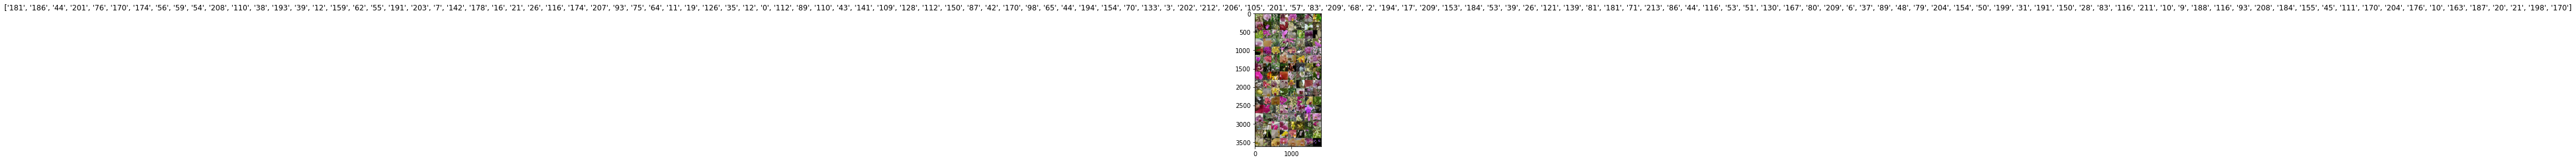

time: 40.7 s (started: 2022-04-09 04:27:51 +00:00)


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              valid_loss.append(epoch_loss)
              valid_acc.append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    plt.figure(figsize=[20, 7])
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, color='green', label='train_loss')
    plt.plot(valid_loss, color='red', label='valid_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, color='green', label='train_acc')
    plt.plot(valid_acc, color='red', label='valid_acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

time: 118 ms (started: 2022-04-11 02:33:43 +00:00)


### Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

time: 12.9 ms (started: 2022-04-09 12:53:21 +00:00)


### Finetuning the Efficientnet

In [ ]:
model_ft = models.efficientnet_b7(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 219)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

time: 5.59 s (started: 2022-04-10 07:49:41 +00:00)


### Train and evaluate

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49
----------
train Loss: 5.4496 Acc: 0.0502
val Loss: 4.5301 Acc: 0.1142

Epoch 1/49
----------
train Loss: 3.5770 Acc: 0.1929
val Loss: 4.1758 Acc: 0.1849

Epoch 2/49
----------
train Loss: 2.7501 Acc: 0.3299
val Loss: 3.2883 Acc: 0.2877

Epoch 3/49
----------
train Loss: 2.1639 Acc: 0.4441
val Loss: 3.7243 Acc: 0.3744

Epoch 4/49
----------
train Loss: 1.7018 Acc: 0.5571
val Loss: 2.7722 Acc: 0.4612

Epoch 5/49
----------
train Loss: 1.3715 Acc: 0.6210
val Loss: 1.9936 Acc: 0.5320

Epoch 6/49
----------
train Loss: 0.8703 Acc: 0.7608
val Loss: 0.8922 Acc: 0.7511

Epoch 7/49
----------
train Loss: 0.7179 Acc: 0.8008
val Loss: 0.7815 Acc: 0.7763

Epoch 8/49
----------
train Loss: 0.6098 Acc: 0.8345
val Loss: 0.7409 Acc: 0.7740

Epoch 9/49
----------
train Loss: 0.4836 Acc: 0.8750
val Loss: 0.7509 Acc: 0.7831

Epoch 10/49
----------
train Loss: 0.4547 Acc: 0.8687
val Loss: 0.7181 Acc: 0.7854

Epoch 11/49
----------
train Loss: 0.4326 Acc: 0.8898
val Loss: 0.7181 Acc: 0.7900

Ep

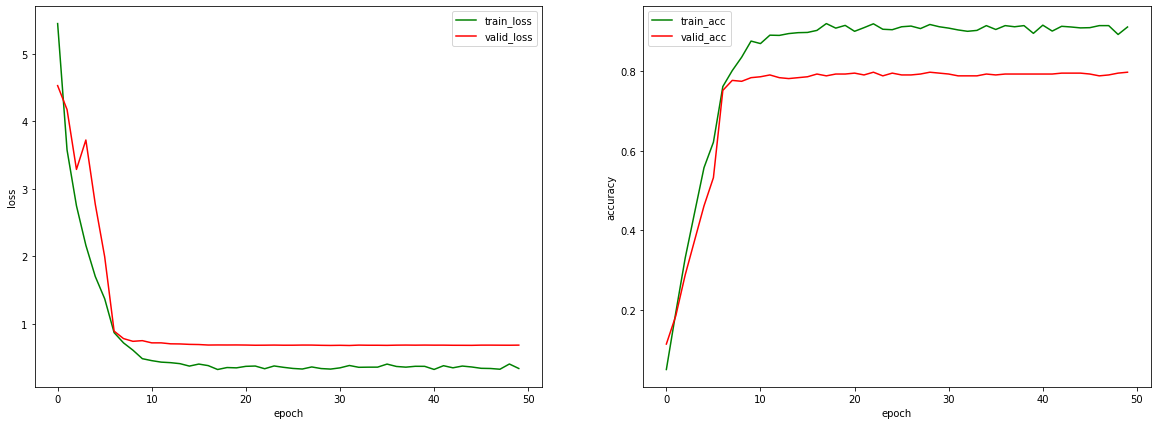

time: 1h 5min 6s (started: 2022-04-10 07:49:46 +00:00)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

NameError: ignored

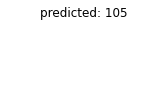

time: 890 ms (started: 2022-04-09 13:42:07 +00:00)


In [ ]:
visualize_model(model_ft)

### Finetuning the SENet(101)

In [14]:
import torch.hub
model_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_se_resnext101_32x4d', pretrained=True)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


time: 1.37 s (started: 2022-04-11 00:57:31 +00:00)


In [11]:
import torch.hub
model_ft = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    pretrained=True)

Downloading: "https://github.com/moskomule/senet.pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip


TypeError: ignored

time: 1.35 s (started: 2022-04-11 00:52:21 +00:00)


In [11]:
model_ft = torchvision.models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 219)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

time: 14.6 s (started: 2022-04-11 02:33:56 +00:00)


### Train and evaluate

In [ ]:
model_conv = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0/29
----------
train Loss: 5.5305 Acc: 0.0006
val Loss: 5.3920 Acc: 0.0046

Epoch 1/29
----------
train Loss: 5.3747 Acc: 0.0029
val Loss: 5.2716 Acc: 0.0137

Epoch 2/29
----------
train Loss: 5.2275 Acc: 0.0040
val Loss: 4.9727 Acc: 0.0183

Epoch 3/29
----------
train Loss: 5.0038 Acc: 0.0074
val Loss: 4.9420 Acc: 0.0183

Epoch 4/29
----------
train Loss: 4.7678 Acc: 0.0148
val Loss: 4.5634 Acc: 0.0571

Epoch 5/29
----------
train Loss: 4.4845 Acc: 0.0308
val Loss: 4.3868 Acc: 0.0708

Epoch 6/29
----------
train Loss: 4.2487 Acc: 0.0497
val Loss: 7.0310 Acc: 0.0868

Epoch 7/29
----------
train Loss: 3.9204 Acc: 0.0839
val Loss: 3.7534 Acc: 0.1324

Epoch 8/29
----------
train Loss: 3.7804 Acc: 0.1096
val Loss: 3.6533 Acc: 0.1279

Epoch 9/29
----------
train Loss: 3.7134 Acc: 0.1239
val Loss: 3.5121 Acc: 0.1484

Epoch 10/29
----------
train Loss: 3.6220 Acc: 0.1147
val Loss: 3.4328 Acc: 0.1758

Epoch 11/29
----------
train Loss: 3.5648 Acc: 0.1467
val Loss: 3.3874 Acc: 0.2146

Ep

### EfficientNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.efficientnet_b7(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features  # Get number of output neurols in last layer
model_conv.classifier[1] = nn.Linear(num_ftrs, 219)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

time: 5.54 s (started: 2022-04-10 07:14:19 +00:00)


### Train and evaluate

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0/3
----------
train Loss: 2.0636 Acc: 0.6855
val Loss: 2.3669 Acc: 0.5776

Epoch 1/3
----------
train Loss: 2.0446 Acc: 0.6809
val Loss: 2.3860 Acc: 0.5799

Epoch 2/3
----------
train Loss: 2.0689 Acc: 0.6712
val Loss: 2.3793 Acc: 0.5753

Epoch 3/3
----------
train Loss: 2.0793 Acc: 0.6650
val Loss: 2.3700 Acc: 0.5753

Training complete in 1m 43s
Best val Acc: 0.579909


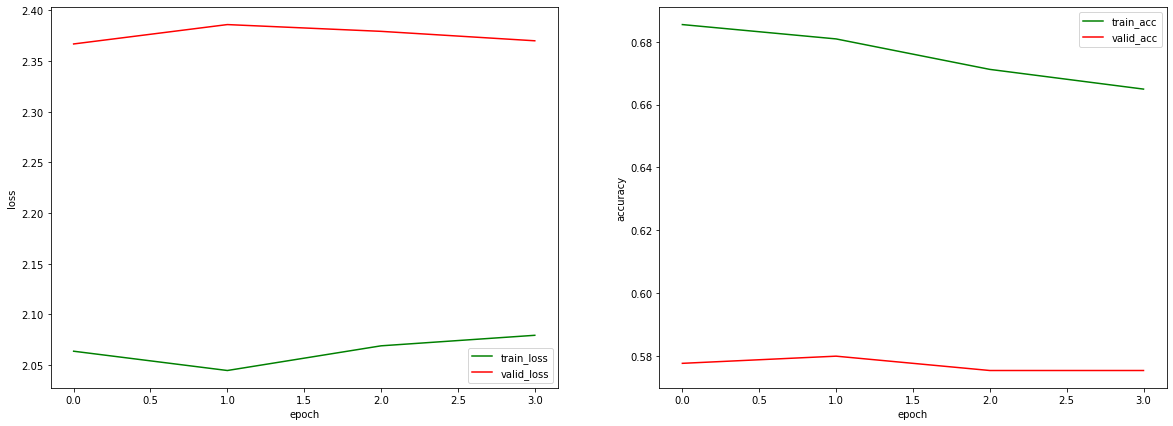

time: 1min 43s (started: 2022-04-10 07:44:35 +00:00)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=4)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()